# Figure 2: Hill's Diversity Analysis of Protein Family Trees

**Purpose:** Calculate and visualize Hill's diversity across protein families  
**Output:** Scatterplots of diversity metrics and example phylogenies

## Setup and Configuration

In [ ]:
# Load required libraries and utility functions
suppressMessages(source("code/utils/utils.R"))

## Download Ensembl compara trees

In [8]:
system('mkdir data/')
system('mkdir data/trees/')
system('wget -P data/ https://ftp.ensembl.org/pub/release-114/emf/ensembl-compara/homologies/Compara.114.protein_default.nh.emf.gz')

## Extract trees

In [9]:
system('python3 code/utils/fig2_extract_trees.py --emf_file data/Compara.114.protein_default.nh.emf.gz --output_dir data/trees/')

## Data Loading and File Discovery

In [10]:
# Set working directory
setwd('~/Desktop/2025-phylogenies-and-bfms/data/trees/')

# List all tree files (exclude taxonomy files)
files <- list.files()

print(paste("Total tree files found:", length(files)))
print("First 10 files:")
print(head(files, 10))

[1] "Total tree files found: 54399"
[1] "First 10 files:"
 [1] "1600014C23Rik_35934.nh" "1700001K19Rik_16728.nh" "1700003H04Rik_32802.nh"
 [4] "1700006A11Rik_16256.nh" "1700012A03Rik_36544.nh" "1700012B07Rik_17003.nh"
 [7] "1700013D24Rik_17011.nh" "1700013G24Rik_16906.nh" "1700014B07Rik_54087.nh"
[10] "1700015E13Rik_26862.nh"


## Hill's Diversity Calculation

Calculate normalized Hill's diversity for each protein family tree

In [11]:
# Initialize storage for Hill diversity values
hill_values <- list()

# Progress bar for tree processing
pb <- txtProgressBar(
  min = 1,
  max = length(files),
  style = 3,
  width = 100,
  char = "."
)

print("Processing trees...")

[1] "Processing trees..."


In [12]:
# Calculate Hill diversity for each tree
for (i in 1:length(files)) {
  # Update progress indicator
  setTxtProgressBar(pb, i)
  
  # Load phylogenetic tree
  tree <- ape::read.tree(files[i])
  
  # Calculate normalized Hill diversity metrics
  hill_values[[as.character(files[i])]] <- normalize_hill_q1(tree)
}

close(pb)
print("\nProcessing complete!")
print(paste("Processed", length(hill_values), "trees"))

  |....................................................................................................| 100%
[1] "\nProcessing complete!"
[1] "Processed 54399 trees"


## Data Filtering

Filter trees with at least 100 tips for statistical robustness

In [13]:
# Filter trees with at least 100 tips for statistical robustness
hill_values_filter <- hill_values[lapply(hill_values, function(x) length(x$tree$tip.label)) >= 100]

print(paste("Trees before filtering:", length(hill_values)))
print(paste("Trees after filtering (≥100 tips):", length(hill_values_filter)))

# Show distribution of tree sizes
tree_sizes <- unlist(lapply(hill_values_filter, function(x) length(x$tree$tip.label)))
print(paste("Tree size range:", min(tree_sizes), "to", max(tree_sizes), "tips"))
print(paste("Median tree size:", median(tree_sizes), "tips"))

[1] "Trees before filtering: 54399"
[1] "Trees after filtering (<U+2265>100 tips): 14054"
[1] "Tree size range: 100 to 1499 tips"
[1] "Median tree size: 209 tips"


## Visualization Data Preparation

In [14]:
# Prepare data for diversity plot
val <- data.frame(x = 1:length(hill_values_filter),
                 y = sort(unlist(lapply(hill_values_filter, function(x) x$Norm_by_tips))))

print("Hill's diversity statistics:")
print(summary(val$y))

# Add row names for tracking
rownames(val) <- names(sort(unlist(lapply(hill_values_filter, function(x) x$Norm_by_tips))))

[1] "Hill's diversity statistics:"
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0007024 0.3593061 0.4151240 0.4084126 0.4652850 0.8328112 


## Branch Length Variance Analysis

Calculate coefficient of variation for branch lengths across families

In [15]:
# Calculate coefficient of variation for branch lengths
br_variance <- list()

print("Calculating branch length variance...")
for (i in 1:length(hill_values_filter)) {
  if (is.null(hill_values_filter[[i]]$tree$edge.length) == FALSE) {
    
    # Extract tree for analysis
    tree <- hill_values_filter[[i]]$tree
    
    # Get all branch lengths (simplified from terminal-only)
    br <- tree$edge.length
    
    # Calculate coefficient of variation (CV = sd/mean)
    br_variance[[names(hill_values_filter)[i]]] <- sd(br) / mean(br)
  } else {
    br_variance[[names(hill_values_filter)[i]]] <- NA
  }
}

print("Branch length variance calculation complete!")

[1] "Calculating branch length variance..."
[1] "Branch length variance calculation complete!"


## Data Alignment and Final Preparation

In [16]:
# Match branch variance order to Hill's diversity values
br_variance <- unlist(br_variance[match(rownames(val), names(br_variance))])
y <- val$y[match(names(br_variance), rownames(val))]

# Prepare data for variance vs diversity plot
val2 <- data.frame(x = y, y = br_variance)

# Remove NA values
val2 <- val2[complete.cases(val2), ]

print("Final dataset statistics:")
print(paste("Families with diversity data:", nrow(val)))
print(paste("Families with both diversity and variance data:", nrow(val2)))
print("Variance statistics:")
print(summary(val2$y))

[1] "Final dataset statistics:"


[1] "Families with diversity data: 14054"
[1] "Families with both diversity and variance data: 14054"
[1] "Variance statistics:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9387  1.6447  1.9191  2.1729  2.3024 53.5342 


## Plot Generation

Create visualizations of Hill's diversity patterns

In [17]:
# Load required plotting libraries
library(ggplot2)
library(gridExtra)

# Plot 1: Hill's diversity distribution across protein families
p1 <- ggplot(data = val,
            aes(x = x,
                y = y,
                color = y)) +
  scale_color_gradientn(colours = arcadia_gradient_palette("magma")$colors) +
  xlab("Protein family #") +
  ylab("Hills diversity (normalized)") +
  geom_point(size = 2, show.legend = FALSE) +
  theme(legend.position = "none") +
  theme_arcadia()

print("Plot 1 created: Hill's diversity distribution")

[1] "Plot 1 created: Hill's diversity distribution"


In [18]:
# Plot 2: Relationship between diversity and branch length variance
p2 <- ggplot(data = val2,
            aes(x = x,
                y = y,
                color = x)) +
  scale_color_gradientn(colours = arcadia_gradient_palette("magma")$colors) +
  xlab("Hills diversity (normalized)") +
  ylab("Variance (mean normalized)") +
  geom_point(size = 2, show.legend = FALSE) +
  theme(legend.position = "none") +
  theme_arcadia()

print("Plot 2 created: Diversity vs variance relationship")

[1] "Plot 2 created: Diversity vs variance relationship"


[1] "Combined plots displayed"


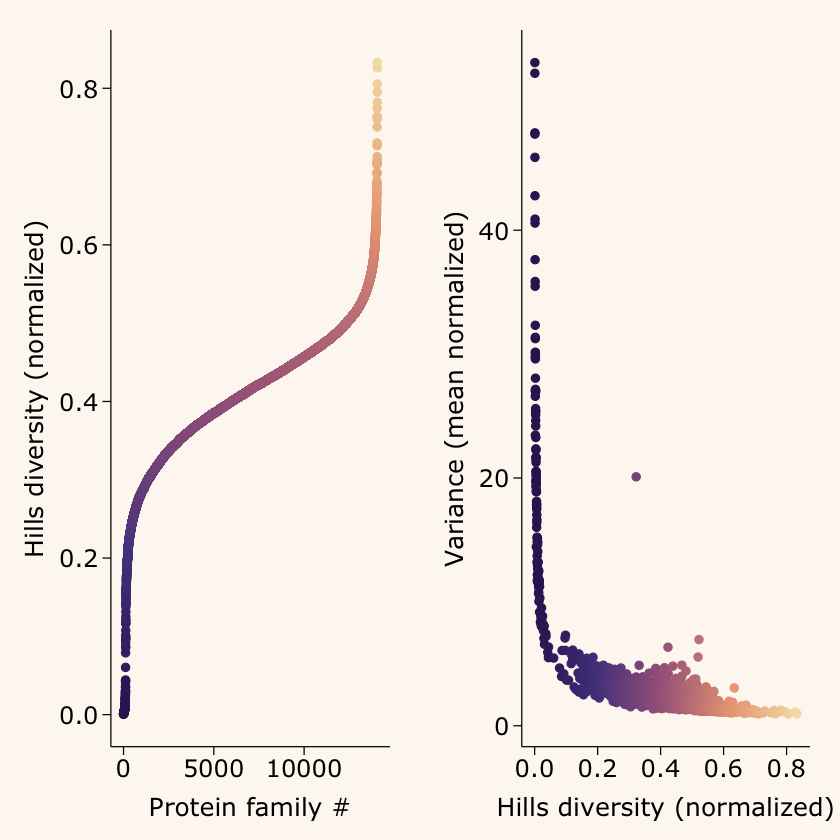

In [19]:
# Display combined plots
grid.arrange(p1, p2, nrow = 1)

print("Combined plots displayed")

## Example Phylogenies

Display representative trees at different diversity levels

In [20]:
# Plot representative trees at different diversity levels
eff_counts <- sort(unlist(lapply(hill_values_filter, function(x) x$Norm_by_tips)))

print("Diversity levels for example trees:")
print(paste("Minimum:", round(min(eff_counts), 3)))
print(paste("0.2 level:", round(eff_counts[which.min(abs(eff_counts - 0.2))], 3)))
print(paste("0.4 level:", round(eff_counts[which.min(abs(eff_counts - 0.4))], 3)))
print(paste("0.6 level:", round(eff_counts[which.min(abs(eff_counts - 0.6))], 3)))
print(paste("Maximum:", round(max(eff_counts), 3)))

[1] "Diversity levels for example trees:"
[1] "Minimum: 0.001"
[1] "0.2 level: 0.2"
[1] "0.4 level: 0.4"
[1] "0.6 level: 0.6"
[1] "Maximum: 0.833"


[1] "Example phylogenies displayed across diversity gradient"


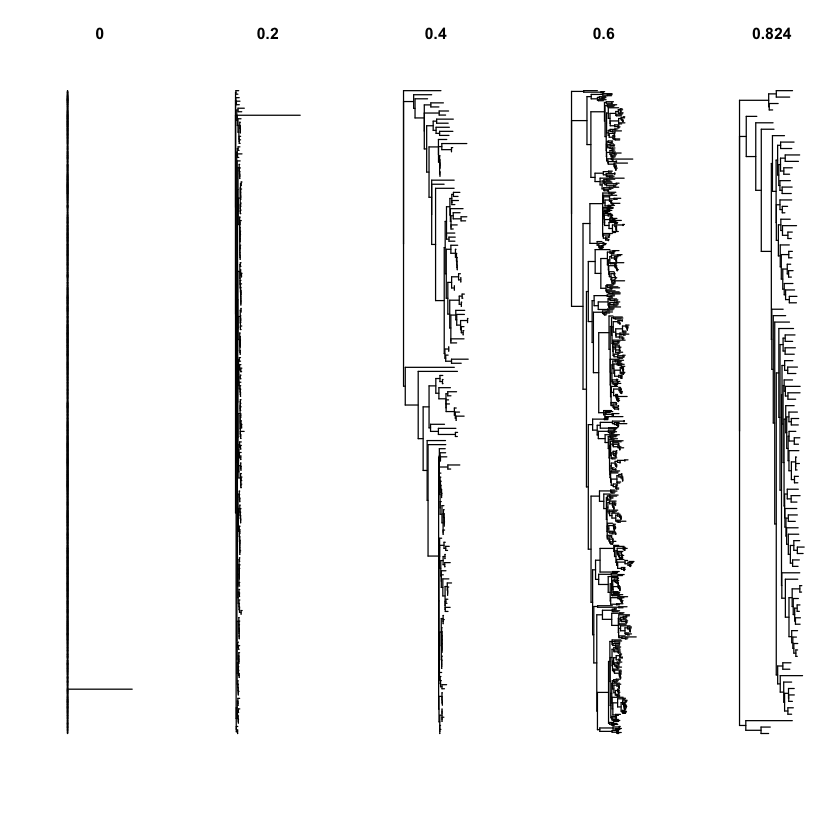

In [21]:
# Set up panel layout for example trees
par(mfrow = c(1, 5))

# Plot trees at different normalized diversity levels
plot(hill_values_filter[names(eff_counts)[1]][[1]]$tree,
     show.tip.label = FALSE, main = "0")
plot(hill_values_filter[names(eff_counts)[which.min(abs(eff_counts - 0.2))]][[1]]$tree,
     show.tip.label = FALSE, main = "0.2")
plot(hill_values_filter[names(eff_counts)[which.min(abs(eff_counts - 0.4))]][[1]]$tree,
     show.tip.label = FALSE, main = "0.4")
plot(hill_values_filter[names(eff_counts)[which.min(abs(eff_counts - 0.6))]][[1]]$tree,
     show.tip.label = FALSE, main = "0.6")
plot(hill_values_filter[names(eff_counts)[which.min(abs(eff_counts - 1))]][[1]]$tree,
     show.tip.label = FALSE, main = "0.824")

print("Example phylogenies displayed across diversity gradient")

## Summary Statistics and Results

In [22]:
# Generate summary statistics
cat("\n=== ANALYSIS SUMMARY ===\n")
cat("Total protein families processed:", length(hill_values), "\n")
cat("Families with ≥100 tips:", length(hill_values_filter), "\n")
cat("Families with complete data:", nrow(val2), "\n")
cat("\nHill's Diversity Range:", round(min(val$y), 3), "to", round(max(val$y), 3), "\n")
cat("Branch Length Variance Range:", round(min(val2$y, na.rm=TRUE), 3), "to", round(max(val2$y, na.rm=TRUE), 3), "\n")

# Calculate correlation between diversity and variance
correlation <- cor(val2$x, val2$y, use="complete.obs")
cat("\nCorrelation (diversity vs variance):", round(correlation, 3), "\n")


=== ANALYSIS SUMMARY ===
Total protein families processed: 54399 
Families with <U+2265>100 tips: 14054 
Families with complete data: 14054 

Hill's Diversity Range: 0.001 to 0.833 
Branch Length Variance Range: 0.939 to 53.534 

Correlation (diversity vs variance): -0.559 


## Conclusion

This analysis:
1. Processed phylogenetic trees from multiple protein families
2. Calculated normalized Hill's diversity (q=1) for each family
3. Computed branch length variance metrics
4. Visualized patterns across the diversity gradient
5. Displayed example trees representing different diversity levels

The results show the relationship between phylogenetic diversity and branch length variation across protein families.